# Initilization

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os

from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
import lightgbm as lgb

%matplotlib inline
%config InlineBackend.figure_format = "retina"
plt.style.use("seaborn-whitegrid")
matplotlib.rcParams.update({'font.size': 15})

## Knowledge

Ref.:

https://en.wikipedia.org/wiki/Ion_channel

http://book.bionumbers.org/how-many-ions-pass-through-an-ion-channel-per-second/

https://www.nature.com/articles/s42003-019-0729-3

https://journals.physiology.org/doi/full/10.1152/advan.00006.2002

Take away:

| a|b|
|-|-|
|<img src="https://upload.wikimedia.org/wikipedia/commons/2/2f/Ion_channel.png" width="250"/> | <img src="http://book.bionumbers.org/wp-content/uploads/2014/08/427-f1-ChannelOpenClose-11.png" width="300"/>|

|c|
|-|
|<img src="http://book.bionumbers.org/wp-content/uploads/2014/08/427-f3-IonChannelCalc-1.png" width="560"/>|


- The opening of an ion channel is a fleeting event within a few milliseconds

- Single-channel records can be obtained using the appropriate electrophysiological technique (e.g., patch clamp), and from these records the open probability and the channel conductance can be calculated. 


## Load data

In [2]:
def read_data():
    train = pd.read_csv('./data/train_clean_kalman.csv',
                        dtype={
                            'time': np.float32,
                            'signal': np.float32,
                            'open_channels': np.int32
                        })
    
    test = pd.read_csv('./data/test_clean_kalman.csv',
                       dtype={
                           'time': np.float32,
                           'signal': np.float32
                       })
    return train, test

df_train, df_test = read_data()

# Exploratory data analysis (EDA)

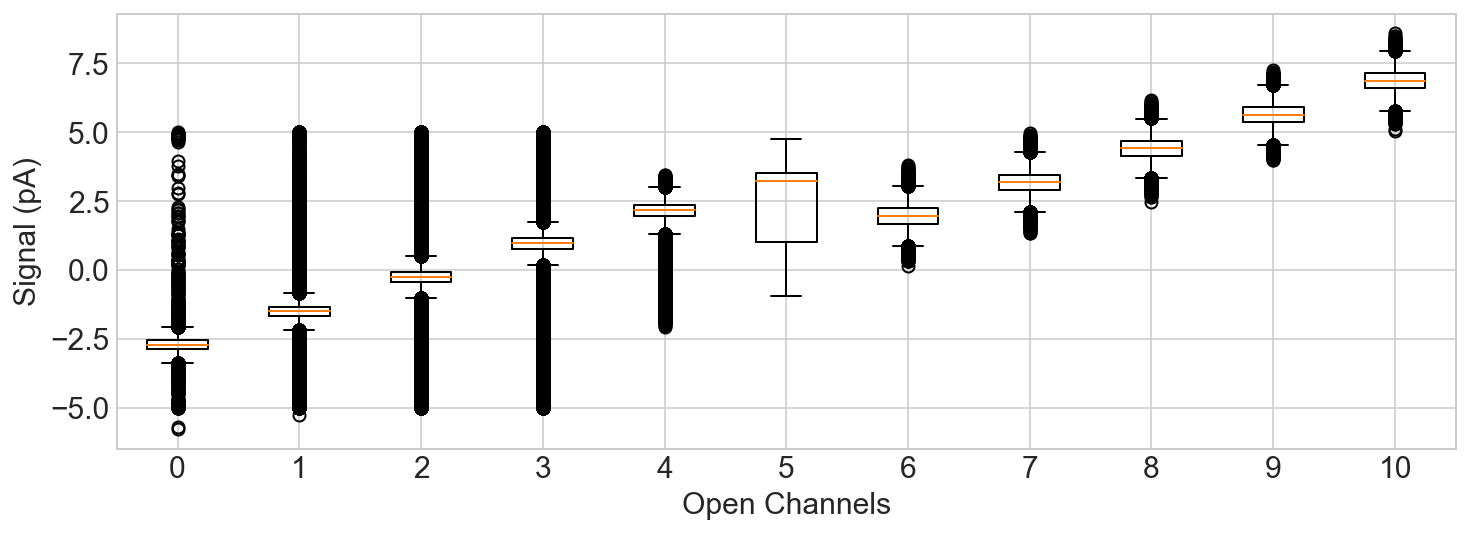

In [14]:
def boxplot_channel(df_train):
    # check quantiles of open channels corresponding to signal
    fig, ax = plt.subplots(1, 1, figsize= (12, 4))
    
    signal = []
    # sort number of channels
    n_channel = np.sort(df_train.open_channels.unique())
    
    # boxplots
    for val in n_channel:
        signal.append(df_train[df_train.open_channels == val].signal)
        
    ax.boxplot(signal)
    ax.set_xticklabels(n_channel)
    ax.set_xlabel('Open Channels')
    ax.set_ylabel('Signal (pA)')

    plt.show()

boxplot_channel(df_train)

Number of training batches: 10.0
Signal Batch (fragment):  0


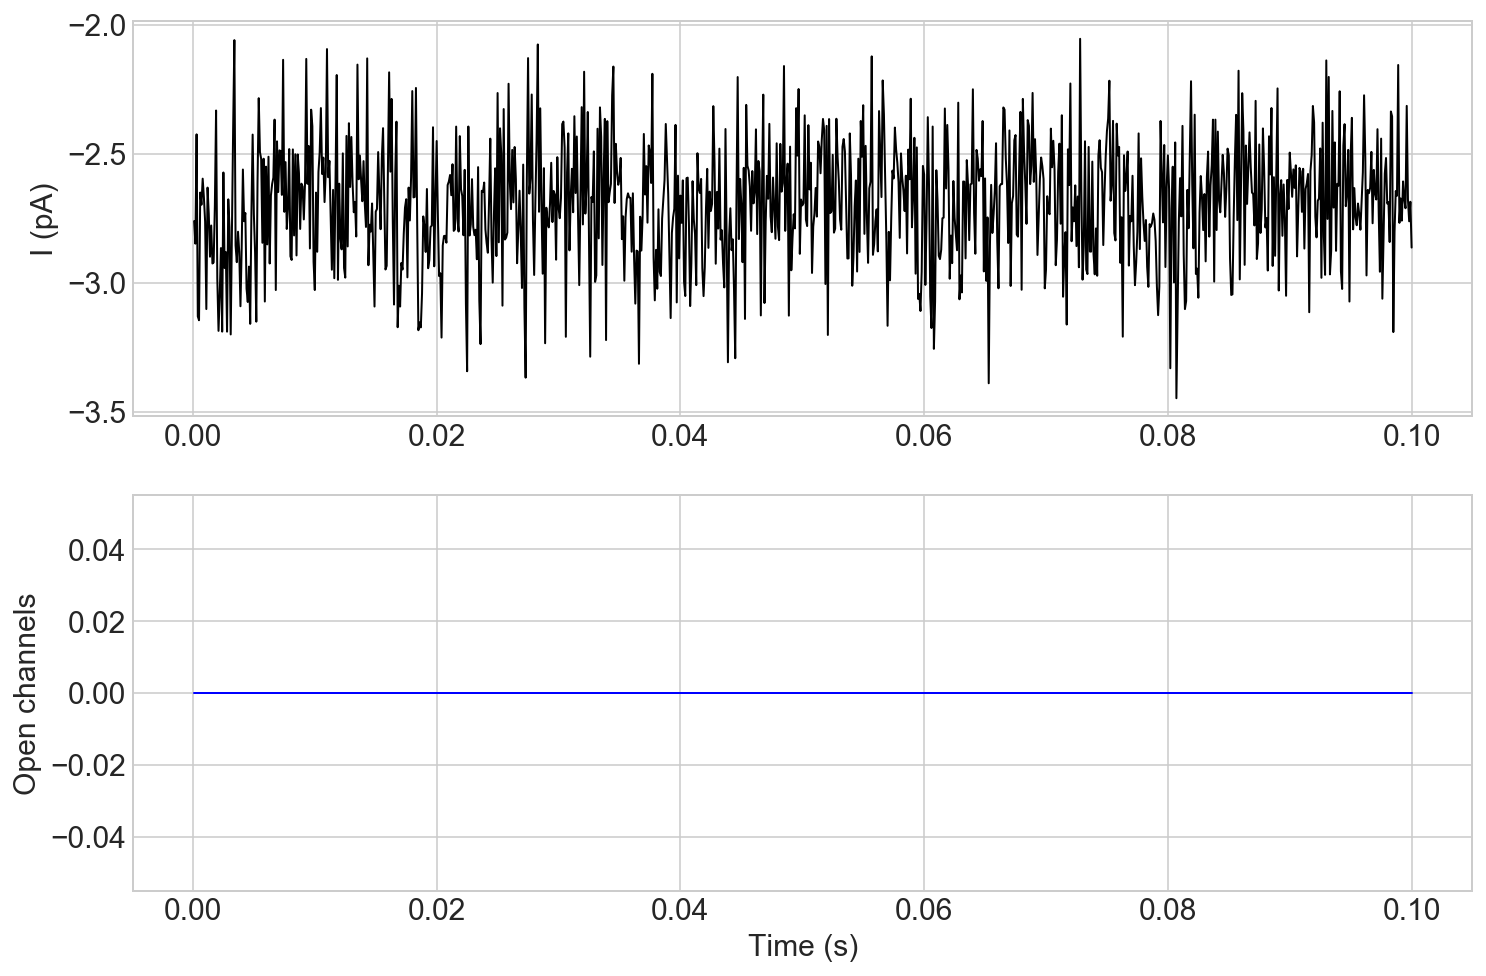

Signal Batch (fragment):  1


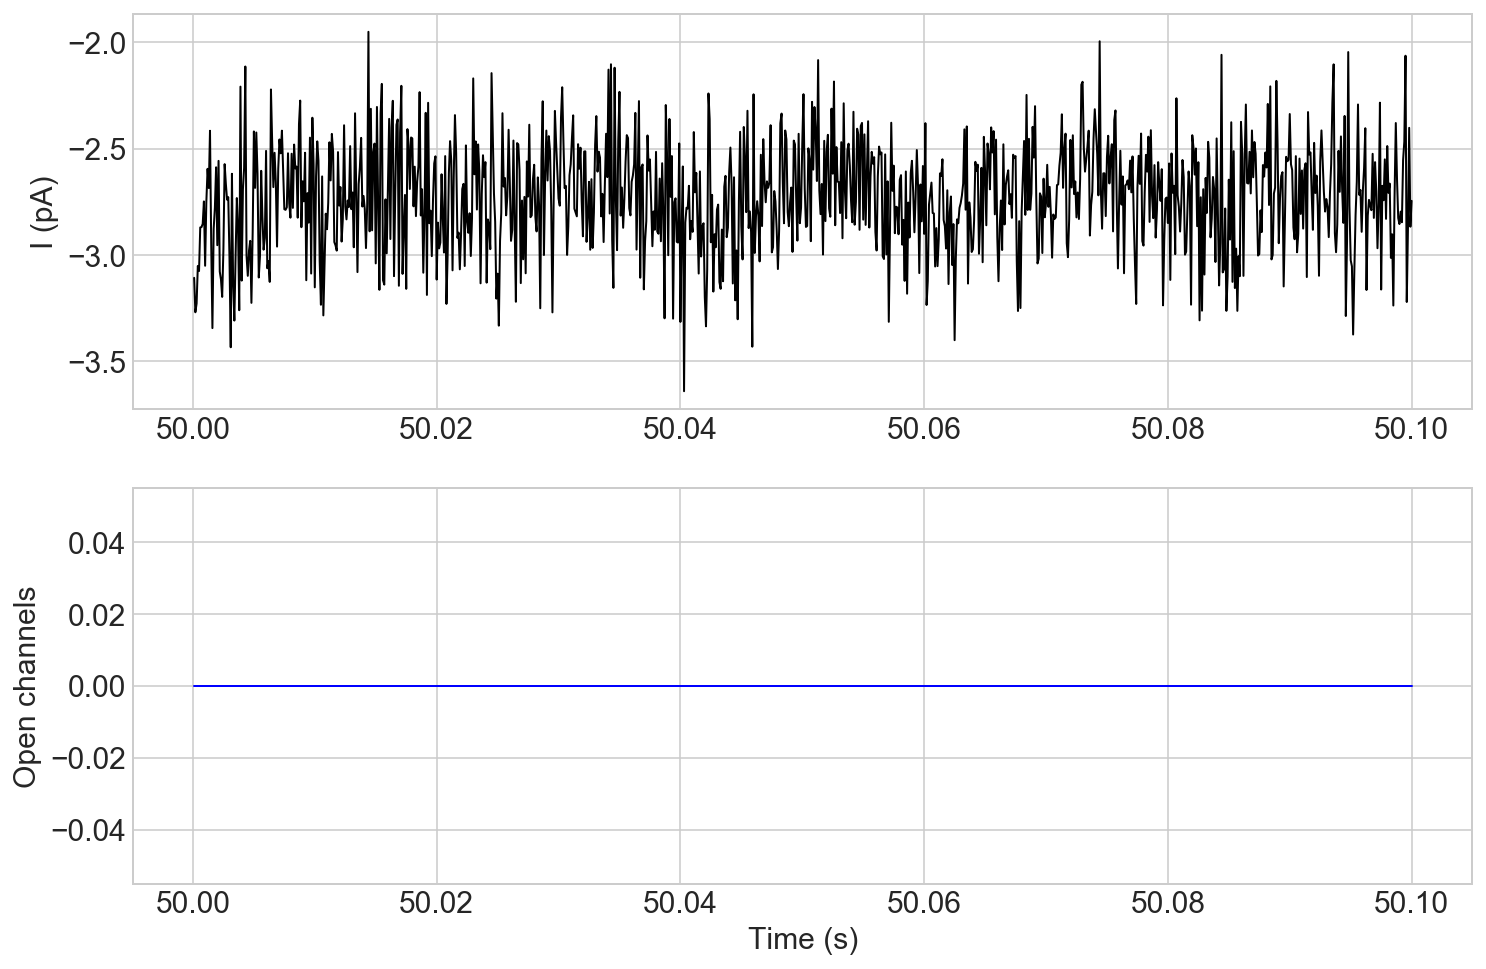

Signal Batch (fragment):  2


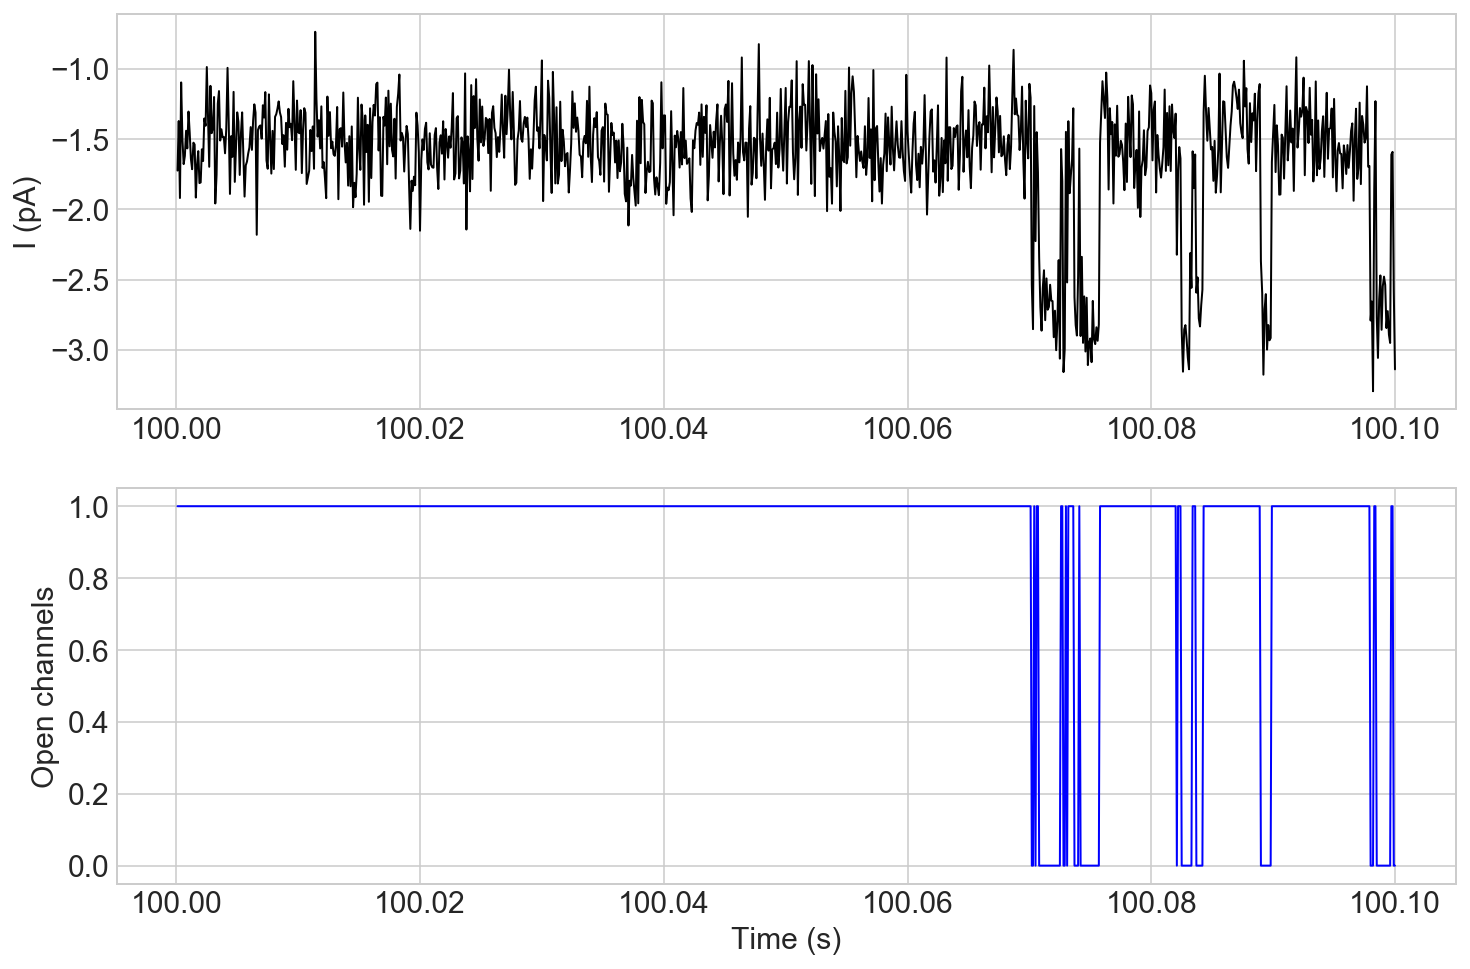

Signal Batch (fragment):  3


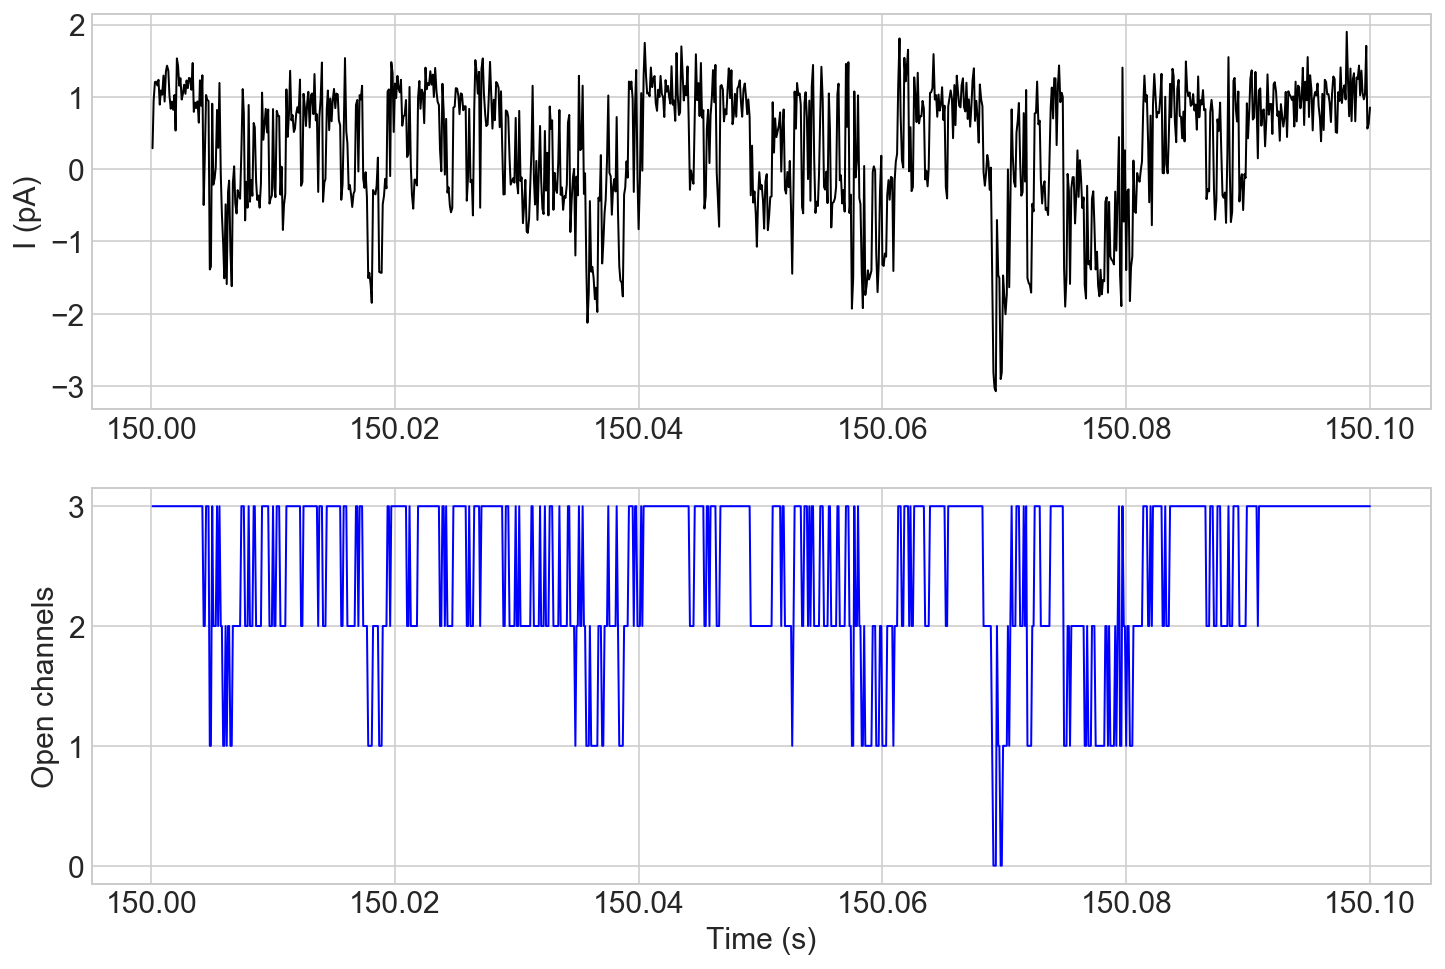

Signal Batch (fragment):  4


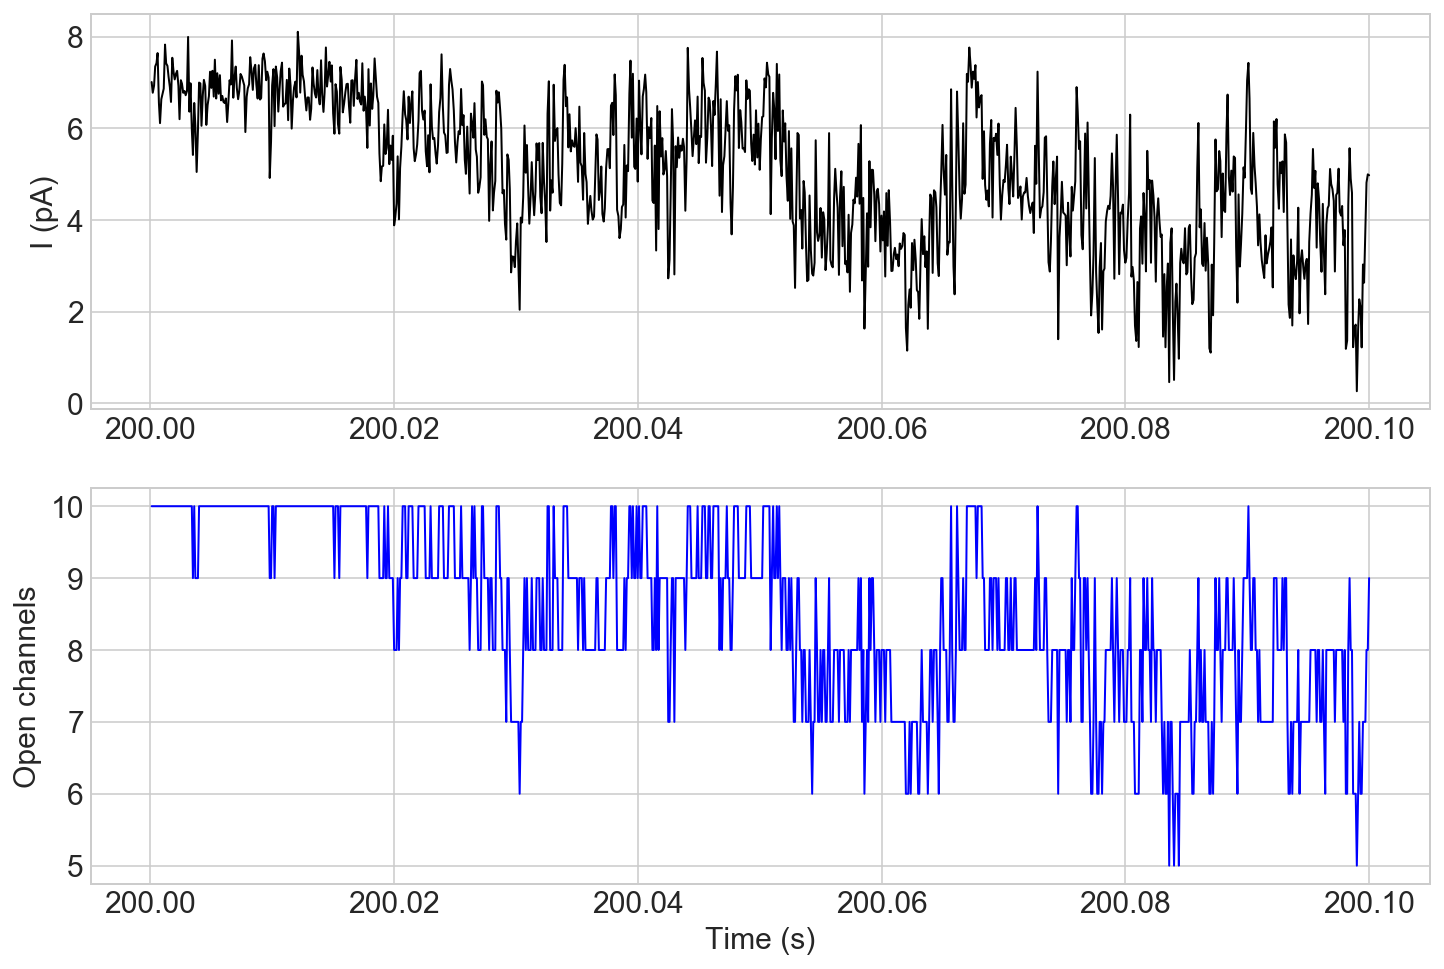

Signal Batch (fragment):  5


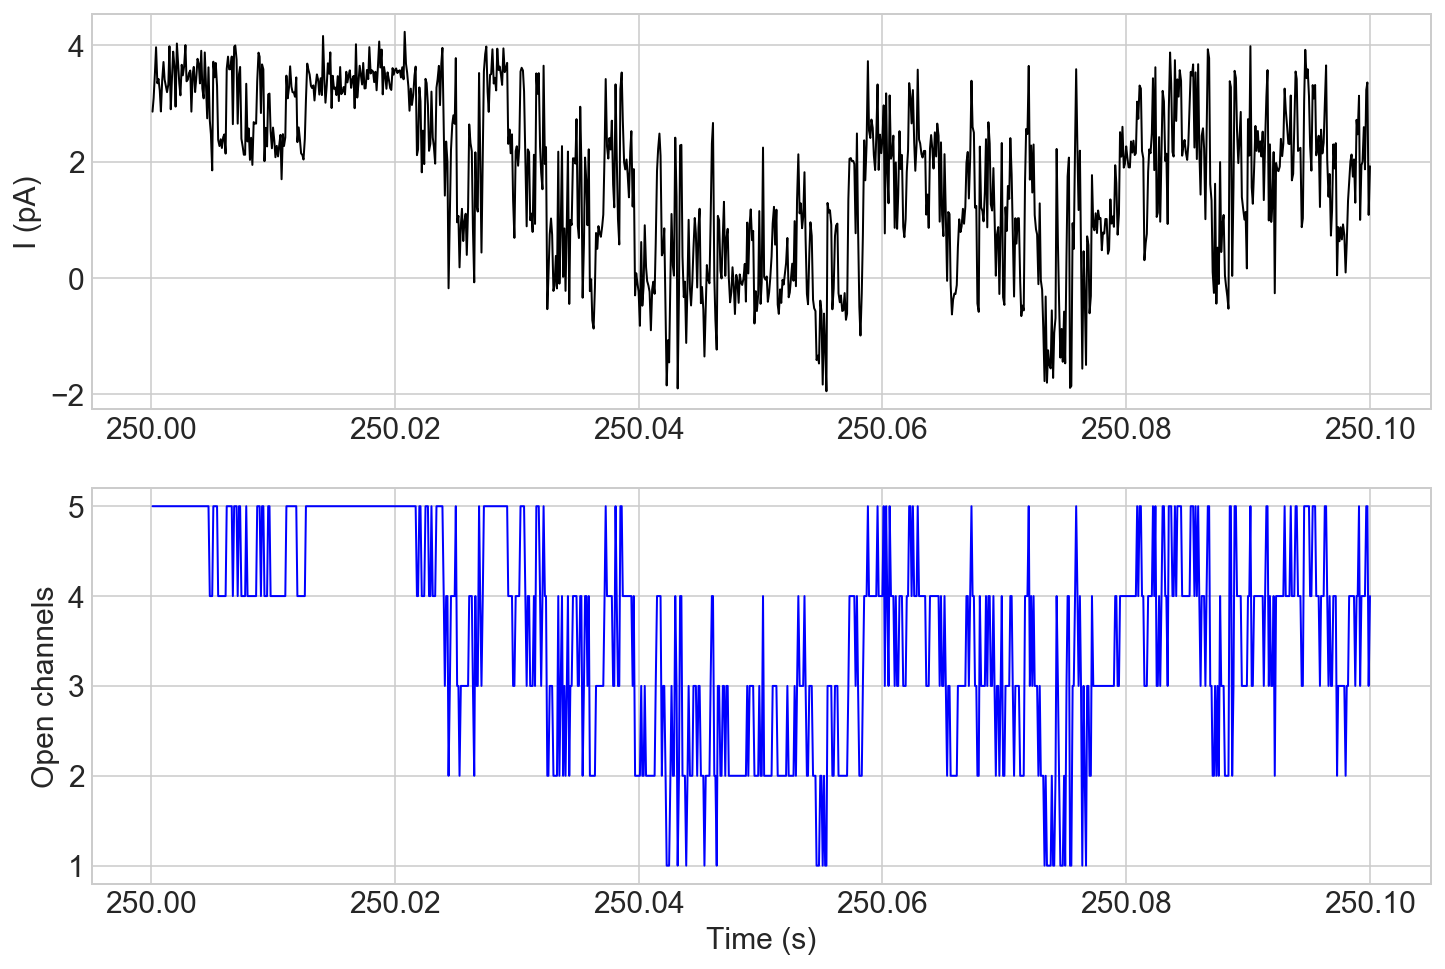

Signal Batch (fragment):  6


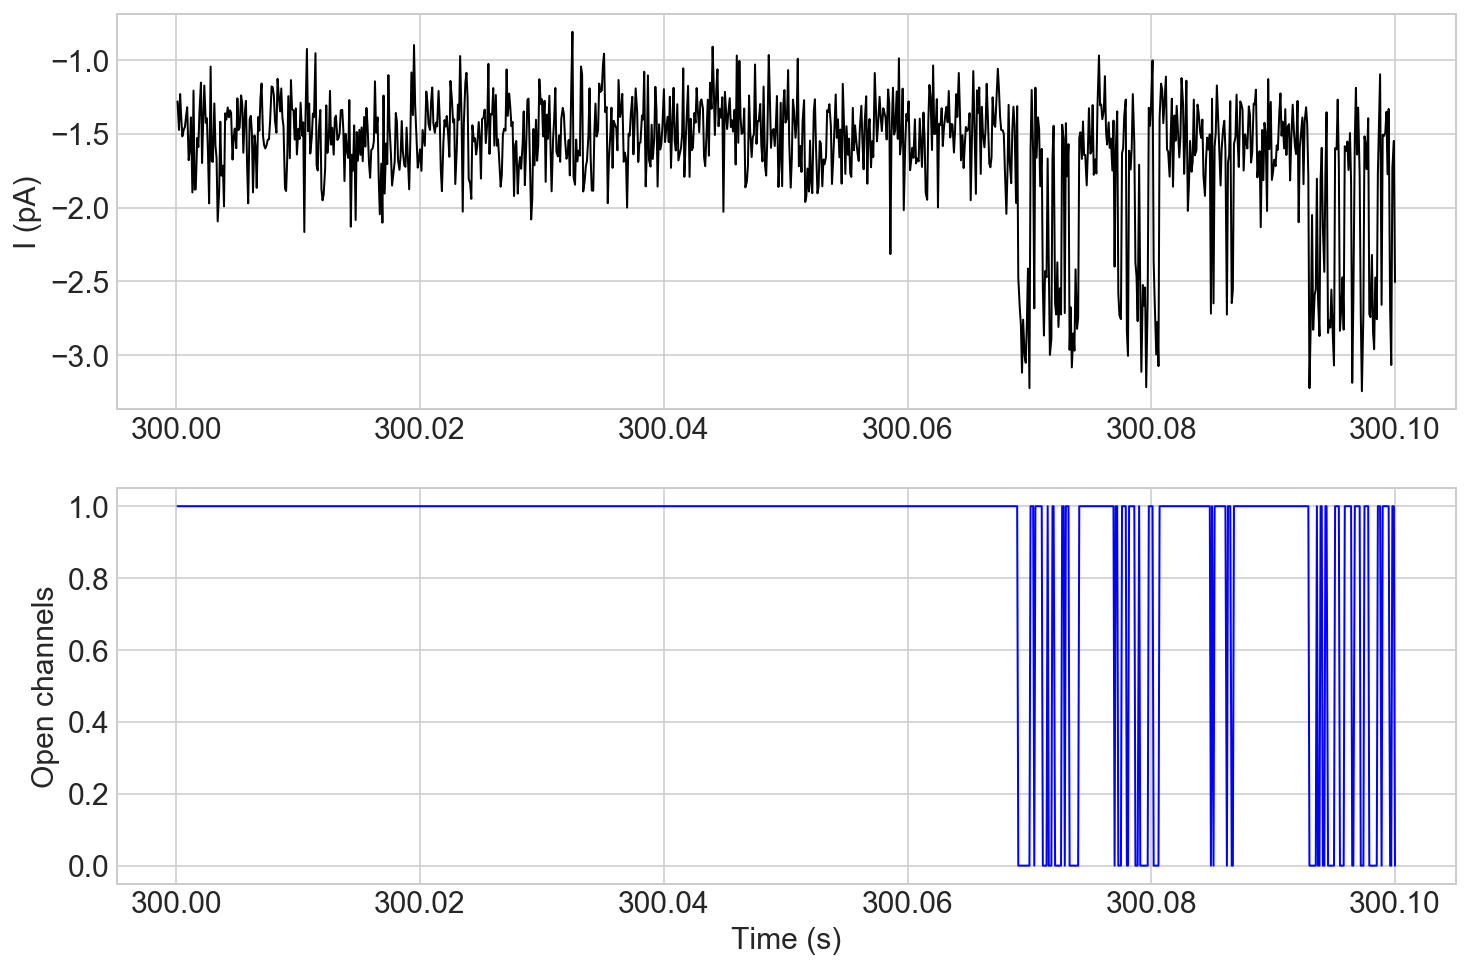

Signal Batch (fragment):  7


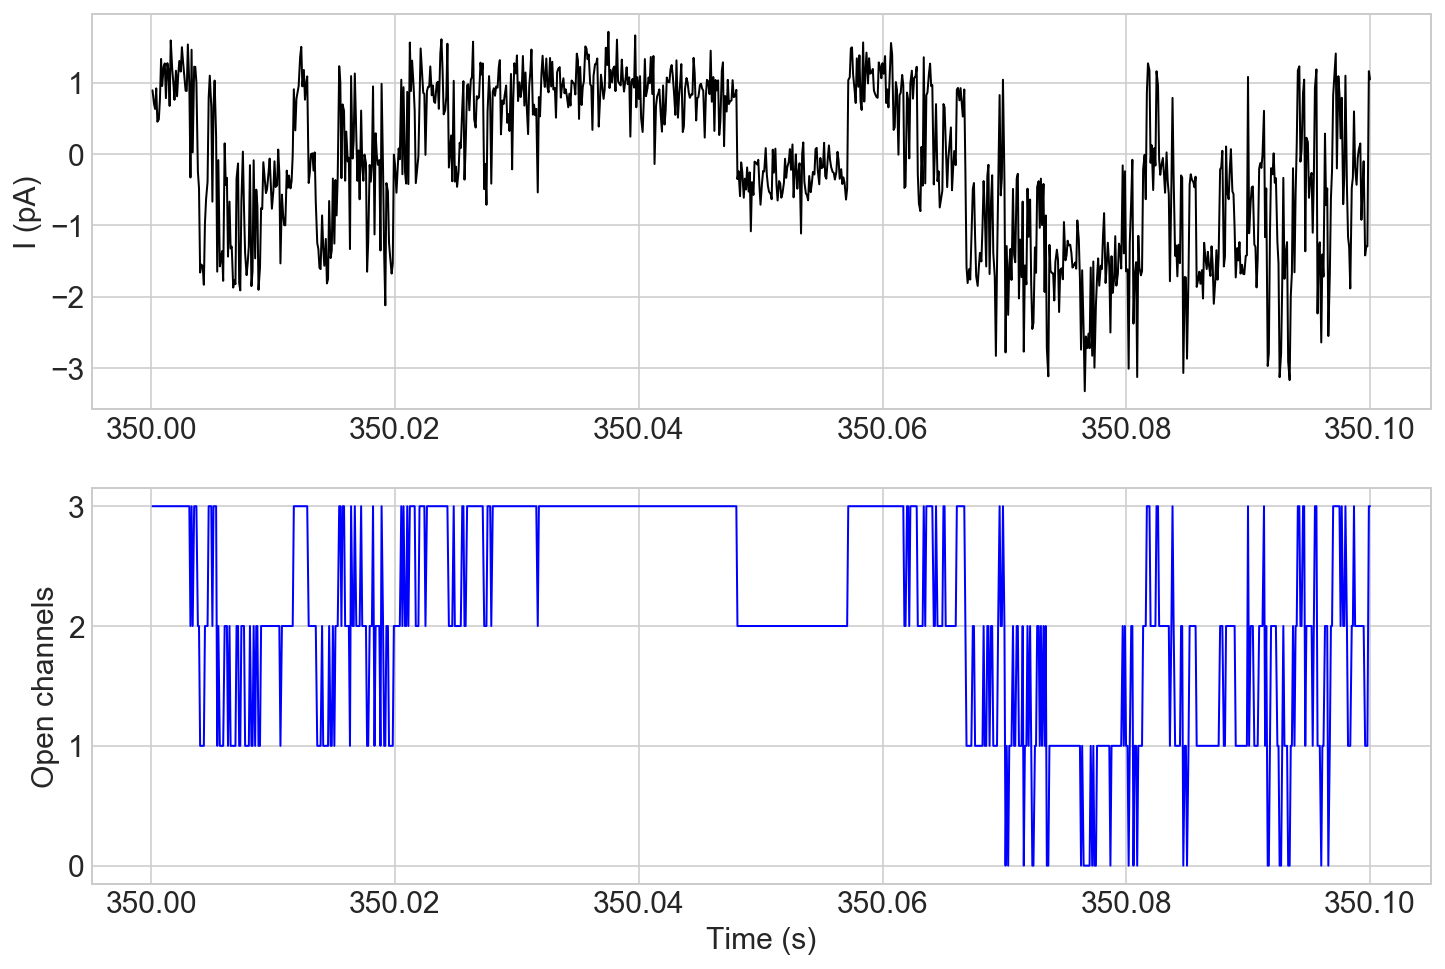

Signal Batch (fragment):  8


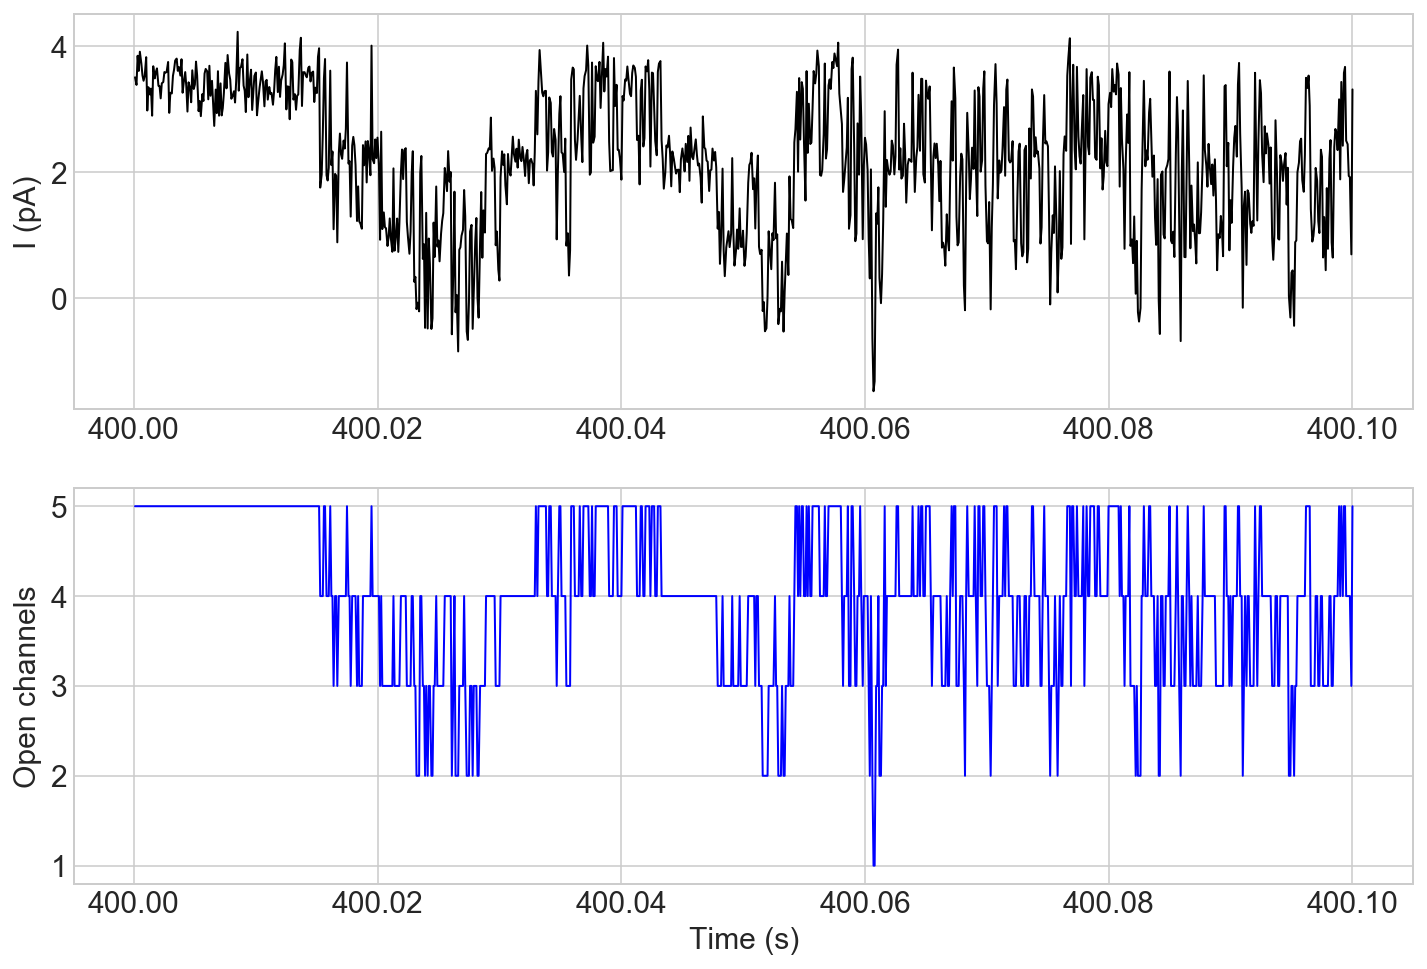

Signal Batch (fragment):  9


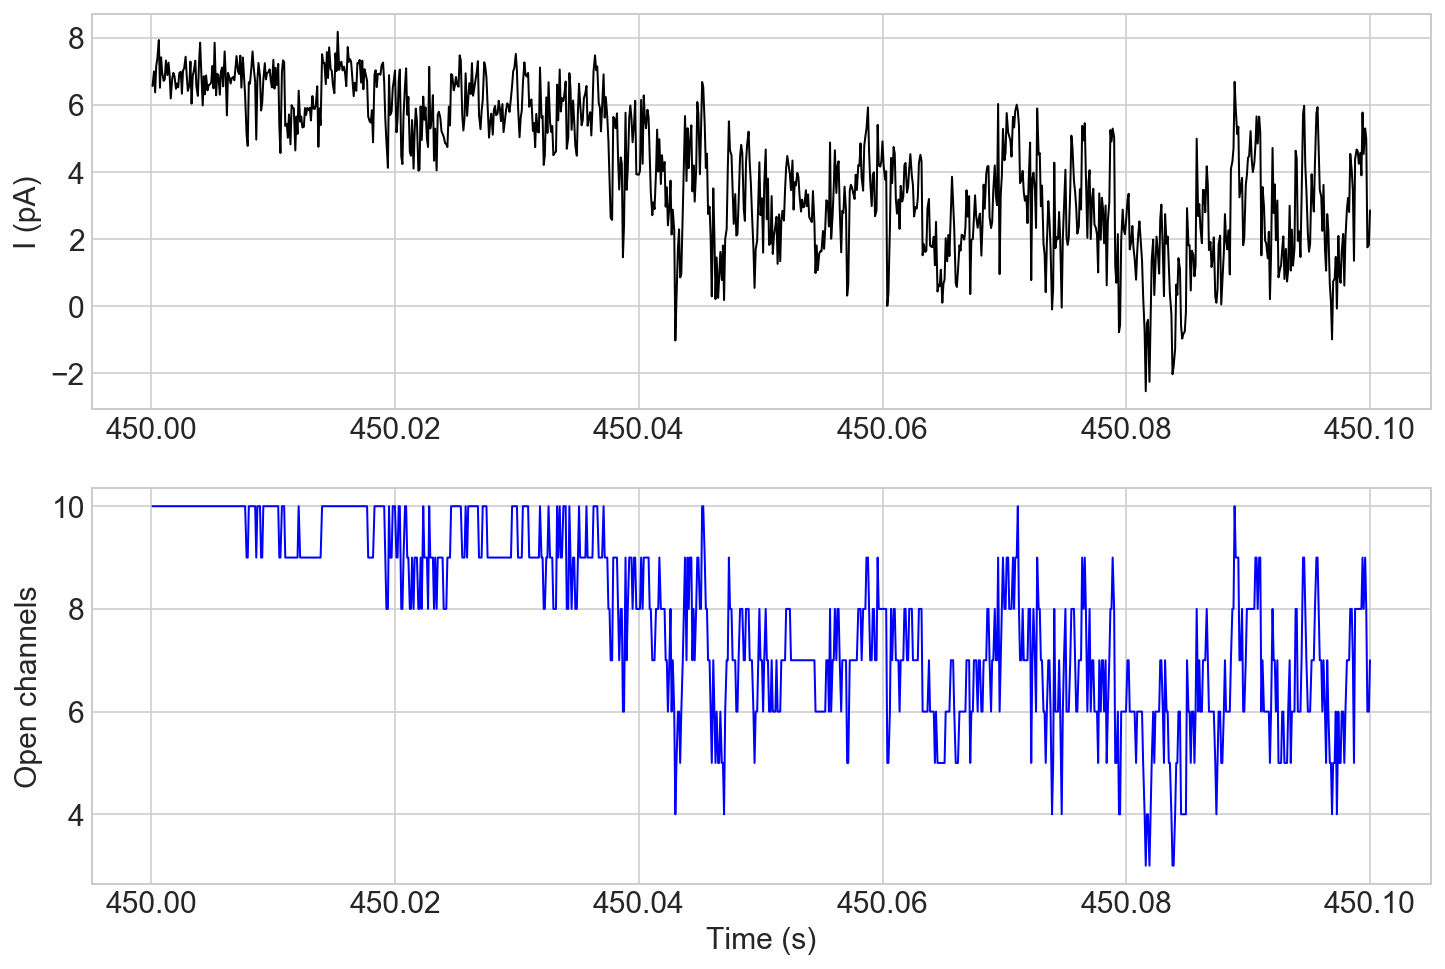

In [15]:
print('Number of training batches:', len(df_train)/500000)

for i in range(int(len(df_train)/500000)):
    print('Signal Batch (fragment): ', i)
    fig, ax1 = plt.subplots(2, 1, figsize=(12,8))
    ax1[0].plot(df_train['time'].iloc[i*500000:i*500000+1000], 
            df_train['signal'].iloc[i*500000:i*500000+1000],
            'k', lw=1)
    ax1[0].set_xlabel('')
    ax1[0].set_ylabel('I (pA)')
    
    ax1[1].plot(df_train['time'].iloc[i*500000:i*500000+1000],
                df_train['open_channels'].iloc[i*500000:i*500000+1000],
                'b', lw=1)
    ax1[1].set_xlabel('Time (s)')
    ax1[1].set_ylabel('Open channels')

    plt.show()

# Feature Engineering

In [7]:
def label_batch(train, test):
    n_samples = 500000
    train['label'] = 'train'
    test['label'] = 'test'

    # concatenate data
    data = pd.concat([train, test], axis=0, ignore_index=True)

    # assign label to batches
    num_batch = int(len(data) / n_samples)
    label = range(1, num_batch + 1)
    data['batch_idx'] = np.repeat(label, n_samples).astype(np.int32)

    return data


def scale_batch(data):
    # scale single for each batch
    scaler = MinMaxScaler()
    s_scaled = data.groupby('batch_idx')['signal'].apply(
        lambda x: scaler.fit_transform(x.values.reshape(-1, 1)).flatten())

    df_scaled = s_scaled.to_frame().explode('signal')
    data['signal_scaled'] = df_scaled['signal'].values.astype(np.float32)
    
    return data

In [8]:
data = label_batch(df_train, df_test)
data = scale_batch(data)

## Feature test

In [7]:
# create batches of 4000 observations
def batching(df, batch_size):
    df['group'] = df.groupby(df.index//batch_size, sort=False)['signal'].agg(['ngroup']).values
    df['group'] = df['group'].astype(np.uint16)
    return df

# normalize the data (standard scaler). We can also try other scalers for a better score!
def normalize(train, test):
    train_input_mean = train.signal.mean()
    train_input_sigma = train.signal.std()
    train['signal'] = (train.signal - train_input_mean) / train_input_sigma
    test['signal'] = (test.signal - train_input_mean) / train_input_sigma
    return train, test

# get lead and lags features
def lag_with_pct_change(df, windows):
    for window in windows:    
        df['signal_shift_pos_' + str(window)] = df.groupby('group')['signal'].shift(window).fillna(0)
        df['signal_shift_neg_' + str(window)] = df.groupby('group')['signal'].shift(-1 * window).fillna(0)
    return df

# main module to run feature engineering. Here you may want to try and add other features and check if your score imporves :).
def run_feat_engineering(df, batch_size):
    # create batches
    df = batching(df, batch_size = batch_size)
    # create leads and lags (1, 2, 3 making them 6 features)
    df = lag_with_pct_change(df, [1, 2, 3])
    # create signal ** 2 (this is the new feature)
    df['signal_2'] = df['signal'] ** 2
    return df

# fillna with the mean and select features for training
def feature_selection(train, test):
    features = [col for col in train.columns if col not in ['index', 'group', 'open_channels', 'time']]
    train = train.replace([np.inf, -np.inf], np.nan)
    test = test.replace([np.inf, -np.inf], np.nan)
    for feature in features:
        feature_mean = pd.concat([train[feature], test[feature]], axis = 0).mean()
        train[feature] = train[feature].fillna(feature_mean)
        test[feature] = test[feature].fillna(feature_mean)
    return train, test, features

In [8]:
batch_size = 4000
t_train, t_test = normalize(df_train, df_test)
t_train = run_feat_engineering(t_train, batch_size)
t_test = run_feat_engineering(t_test, batch_size)
t_train, t_test, features = feature_selection(t_train, t_test)

In [18]:
t_X_train, t_y_train, t_X_test = t_train[features], t_train['open_channels'], t_test[features]

In [20]:
# initialize lightGBM model
parameters = {"objective": 'multiclass', "n_jobs": -1}
lgb_model = lgb.LGBMClassifier(**parameters)
lgb_model.fit(t_X_train, t_y_train)
t_y_pred = lgb_model.predict(t_X_test)

In [22]:
submission = pd.read_csv('./data/sample_submission.csv', dtype={'time': np.float32})
submission['open_channels'] = t_y_pred
submission = submission.astype({'open_channels': np.uint16})
submission.to_csv('submission_test.csv', index=False, float_format='%.4f')

# Models

## LightGBM

In [12]:
def parameter_tuning(data):
    """
    tune selected parameters with RandomizedSearchCV
    """
    print('Tuning parameters ...')
    train = data[data['label'] == 'train'].drop(columns=['label', 'time'])
    X_train = train.drop(columns='open_channels')
    y_train = train['open_channels']

    parameters = {
        'num_leaves': [10, 30, 50, 80],
        'min_data_in_leaf': [100, 300, 700, 1000],
        'learning_rate': [0.05, 0.1, 0.15, 0.2],
    }

    # apply GridSearch on random forest regression to find the best parameter
    model = RandomizedSearchCV(lgb.LGBMClassifier(n_estimators=1000),
                               parameters,
                               cv=5,
                               scoring='f1_macro',
                               n_jobs=-1,
                               verbose=2,
                               n_iter=20)

    model.fit(X_train, y_train)
    print('The best parameters are:\n')
    print(model.best_estimator_)

    mean = model.cv_results_['mean_test_score']
    std = model.cv_results_['std_test_score']
    for mean, std, params in zip(mean, std, model.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

    return model.best_estimator_


def cross_validation(data):
    train = data[data['label'] == 'train'].drop(columns=['label', 'time'])

    X_train = train.drop(columns='open_channels')
    y_train = train['open_channels']

    parameters = {"objective": 'multiclass', "n_jobs": -1}
    lgb_model = lgb.LGBMClassifier(**parameters)
    scores = cross_val_score(lgb_model,
                             X_train,
                             y_train,
                             cv=5,
                             scoring='f1_macro',
                             verbose=1)
    return scores


def model_train(data, valid=True):

    train = data[data['label'] == 'train'].drop(columns=['label', 'time'])
    X = train.drop(columns='open_channels')
    y = y_train = train['open_channels']

    # split train valid sets
    X_train, X_valid, y_train, y_valid = train_test_split(X,
                                                          y,
                                                          test_size=0.2,
                                                          random_state=42)
    # initialize lightGBM model
    parameters = {"objective": 'multiclass', "n_jobs": -1}
    lgb_model = lgb.LGBMClassifier(**parameters)

    if valid:
        # fit the model
        lgb_model.fit(X_train, y_train)

        # validation
        y_pred = lgb_model.predict(X_valid)
        
        print(f'Validation score:', f1_score(y_valid, y_pred, average='macro'))
    else:
        lgb_model.fit(X, y)

    return lgb_model


def submit(model, data):
    X_test = data[data['label'] == 'test'].drop(
        columns=['time', 'open_channels', 'label'])
    y_pred = model.predict(X_test)

    submission = data[data['label'] == 'test'][['time']]
    submission['open_channels'] = y_pred
    submission = submission.astype({'open_channels': np.uint16})
    submission.to_csv('submission.csv', index=False, float_format='%.4f')
    
    return submission

In [13]:
model = model_train(data, valid=False)

In [14]:
submission = submit(model, data)